In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pyemma as pe
import pyemma
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import mdtraj

In [2]:
sys.path.insert(0,'../')
from torchmdnet2.dataset import ChignolinDataset, DataModule
from torchmdnet2.nn import CGnet
from torchmdnet2.models import LNNP, SchNet
from torchmdnet2.utils import LoadFromFile, save_argparse
from torchmdnet2.simulation import Simulation

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

from torch_geometric.data import DataLoader

from torch.nn import Embedding, Sequential, Linear, ModuleList

In [3]:
device = torch.device('cuda')

# utils

In [47]:
def plot_tica(baseline_model, dataset, lag=10, tica=None):
    # compute distances all of the beads
    baseline_model.cpu()
    if isinstance(dataset, np.ndarray):
        n_traj, n_samp, n_beads, _ = traj.shape
        features = []
        for i_traj in range(n_traj):
            _ = baseline_model.geom_feature(torch.from_numpy(traj[i_traj]))
            feat = baseline_model.geom_feature.distances
            features.append(feat)
    else:
        _ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
        feat = baseline_model.geom_feature.distances

        if 'traj_idx' in dataset.data:
            traj_ids = dataset.data.traj_idx
            n_traj = np.unique(traj_ids).shape[0]
            traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

            features = []
            for i_traj in range(n_traj):
                st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
                features.append(feat[st:nd].numpy())
        else:
            features = feat.numpy()
            
    if tica is None:
        tica = pe.coordinates.tica(features, lag=lag, dim=2)
        tica_concatenated = np.concatenate(tica.get_output())
    else:
        Xproj = tica.transform(features)
        tica_concatenated = np.concatenate(Xproj)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    pyemma.plots.plot_feature_histograms(
        tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
    pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
    pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
    for ax in axes.flat[1:]:
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
    fig.tight_layout()
    return fig, axes, tica

In [5]:
from torch_geometric.data.data import size_repr

from argparse import Namespace
class Args(Namespace):
    def __init__(self,**kwargs):
        for key, item in kwargs.items():
            self[key] = item
            
    def __getitem__(self, key):
        r"""Gets the data of the attribute :obj:`key`."""
        return getattr(self, key, None)

    def __setitem__(self, key, value):
        """Sets the attribute :obj:`key` to :obj:`value`."""
        setattr(self, key, value)

    @property
    def keys(self):
        r"""Returns all names of graph attributes."""
        keys = [key for key in self.__dict__.keys() if self[key] is not None]
        keys = [key for key in keys if key[:2] != '__' and key[-2:] != '__']
        return keys

    def __len__(self):
        r"""Returns the number of all present attributes."""
        return len(self.keys)

    def __contains__(self, key):
        r"""Returns :obj:`True`, if the attribute :obj:`key` is present in the
        data."""
        return key in self.keys

    def __iter__(self):
        r"""Iterates over all present attributes in the data, yielding their
        attribute names and content."""
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        r"""Iterates over all attributes :obj:`*keys` in the data, yielding
        their attribute names and content.
        If :obj:`*keys` is not given this method will iterative over all
        present attributes."""
        for key in sorted(self.keys) if not keys else keys:
            if key in self:
                yield key, self[key]
                
    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return '{}({})'.format(cls, ', '.join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return '{}(\n{}\n)'.format(cls, ',\n'.join(info))


# load and explore the chignolin dataset

In [3]:
dataset = ChignolinDataset('/local/scratch/chignolin/')

In [4]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [5]:
# get the prior model used to modify the forces
baseline_model = dataset.get_baseline_model()

## TICA plot of the reference trajectory

In [10]:
# compute distances all of the beads
_ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
feat = baseline_model.geom_feature.distances

In [22]:
traj_ids = dataset.data.traj_idx
n_traj = np.unique(traj_ids).shape[0]
traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

features = []
for i_traj in range(n_traj):
    st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
    features.append(feat[st:nd].numpy())


In [29]:
tica = pe.coordinates.tica(features, lag=10, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

calculate covariances:   0%|          | 0/3741 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

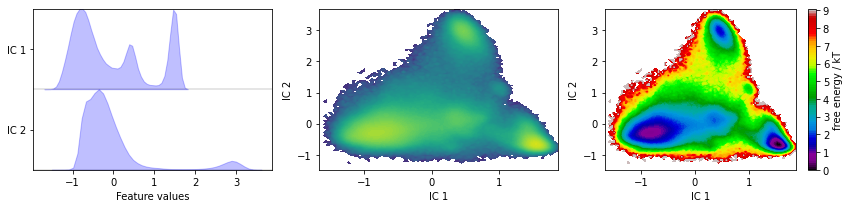

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

# train a CG model

In [30]:
args = Args(**{
    
    'batch_size': 512,
 
    'load_model': None,
    'log_dir': './chign_run/',
    
    'dataset_name': 'chignolin',
    'dataset_root': '/local/scratch/chignolin/',
    'dataset_stride' : 1,
    'target_name': 'forces',
    
    'derivative': True,
    'distributed_backend': 'dp',
    'num_nodes': 1,
    'early_stopping_patience': 100,
    'inference_batch_size': 64,
    'label': None,
    
    'activation': 'tanh',
    'embedding_dimension': 128,
    'cutoff_lower': 0.0,
    'cutoff_upper': 30.0,
    'num_filters': 128,
    'num_interactions': 2,
    'num_rbf': 300,
    'trainable_rbf': False,
    'rbf_type': 'gauss',
    'neighbor_embedding': True,
    'cfconv_aggr': 'mean',
    'n_layers' : 1,
    'reduction_factor' : 1,
  
    'lr': 1e-4,
    'lr_factor': 0.999,
    'lr_min': 1e-7,
    'lr_patience': 10,
    'lr_warmup_steps': 0,
    
    'ngpus': -1,
    'num_epochs': 300,
    'num_workers': 2,
    'save_interval': 10,
    'seed': 18574,
    'test_interval': 1,
    'test_ratio': 0.1,
    'val_ratio': 0.1,
    'weight_decay': 0.0,
    'precision': 32,
    
    'data' : None,
    'coords' : None,
    'forces' : None,
    'embed' : None,
    'splits' : None,
})

In [31]:
dm = DataModule(args.dataset_name, args.dataset_root, args.log_dir, args.val_ratio, args.test_ratio, 
           args.splits, args.batch_size, args.inference_batch_size, args.num_workers)

In [32]:
model = SchNet(
    hidden_channels=args.embedding_dimension,
    num_filters=args.num_filters,
    num_interactions=args.num_interactions,
    num_rbf=args.num_rbf,
    rbf_type=args.rbf_type,
    trainable_rbf=args.trainable_rbf,
    activation=args.activation,
    neighbor_embedding=args.neighbor_embedding,
    cutoff_lower=args.cutoff_lower,
    cutoff_upper=args.cutoff_upper,
    derivative=args.derivative,
    cfconv_aggr=args.cfconv_aggr,
)

In [33]:
pl.seed_everything(args.seed)


checkpoint_callback = ModelCheckpoint(
    dirpath=args.log_dir,
    monitor='val_loss',
    save_top_k=10, # -1 to save all
    period=args.save_interval,
    filename="{epoch}-{val_loss:.4f}-{test_loss:.4f}"
)
early_stopping = EarlyStopping('val_loss', patience=args.early_stopping_patience)

tb_logger = pl.loggers.TensorBoardLogger(args.log_dir, name='tensorbord', version='')
csv_logger = pl.loggers.CSVLogger(args.log_dir, name='', version='')


trainer = pl.Trainer(
    max_epochs=args.num_epochs,
    gpus=args.ngpus,
    num_nodes=args.num_nodes,
    distributed_backend=args.distributed_backend,
    default_root_dir=args.log_dir,
    auto_lr_find=False,
    resume_from_checkpoint=args.load_model,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping],
    logger=[tb_logger, csv_logger],
    reload_dataloaders_every_epoch=False,
    precision=args.precision,
)

Global seed set to 18574
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [34]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./chign_run/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name               | Type              | Params
---------------------------------------------------------
0 | embedding          | Embedding         | 12.8 K
1 | distance_expansion | GaussianSmearing  | 0     
2 | neighbor_embedding | NeighborEmbedding | 84.2 K
3 | interactions       | ModuleList        | 208 K 
4 | mlp                | Sequential        | 33.2 K
---------------------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.356     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not determine on which device the inputs are. When using DataParallel (accelerator='dp'), be aware that in case you are using self.device in your code, it will reference only the root device.
  warnings.warn(*args, **kwargs)
Global seed set to 18574
/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increas

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [ ]:
torch.save(model, os.path.join(args.log_dir, 'last_model.pt'))

In [19]:
checkpoint_callback.best_model_path

''

In [18]:
aa = trainer.optimizers[0]
aa.param_groups[0]['lr']

0.00020971520000000012

In [12]:
aa = trainer.lr_schedulers[0]['scheduler']
aa.

In [8]:
# run test set after completing the fit
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


train 14951, val 1869, test 1869


/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_loss': 21.610315322875977}
--------------------------------------------------------------------------------


[{'avg_loss': 21.610315322875977}]

# run a simulation

In [28]:
# !rm -rf /local/git/torchmd-net2/notebooks/chign_run/*

In [20]:
!ls -lah /local/git/torchmd-net2/notebooks/chign_run/

total 15M
drwxr-xr-x 3 musil cosmo 4.0K May  7 10:34 .
drwxr-xr-x 5 musil cosmo 4.0K May  7 17:21 ..
-rw-r--r-- 1 musil cosmo    3 May  8 01:59 hparams.yaml
-rw-r--r-- 1 musil cosmo 2.8K May  8 01:59 metrics.csv
-rw-r--r-- 1 musil cosmo  15M May  7 10:25 splits.npz
drwxr-xr-x 2 musil cosmo 4.0K May  7 10:25 tensorbord


In [22]:
# model = LNNP.load_from_checkpoint(
#     '/local/git/torchmd-net2/notebooks/chign_run/epoch=29-val_loss=740.0255-test_loss=0.0000.ckpt'
# )
chignolin_dataset = ChignolinDataset('/local/scratch/chignolin/')

In [23]:
n_sims = 1000
n_timesteps = 10000
save_interval = 10

In [24]:
baseline_model = chignolin_dataset.get_baseline_model()

In [25]:
ids = np.arange(0, len(chignolin_dataset),len(chignolin_dataset)//n_sims).tolist()
init = chignolin_dataset[ids]
initial_coords = torch.cat([init[i].pos.reshape((1,-1,3)) for i in range(len(init))], dim=0).to(device=device)
initial_coords.requires_grad_()

sim_embeddings = torch.cat([init[i].z.reshape((1,-1)) for i in range(len(init))], dim=0).to(device=device)

chignolin_net = CGnet(model, baseline_model).eval()
chignolin_net.to(device=device)

CGnet(
  (model): SchNet(hidden_channels=128, num_filters=128, num_interactions=2, num_rbf=200, rbf_type=expnorm, activation=tanh, cutoff_lower=0.0, cutoff_upper=30.0, derivative=True)
  (baseline): BaselineModel(
    (geom_feature): GeometryFeature()
    (priors): Sequential(
      (0): HarmonicLayer()
      (1): HarmonicLayer()
      (2): RepulsionLayer()
    )
  )
)

In [26]:
sim = Simulation(chignolin_net, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=baseline_model.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj = sim.simulate()

Generating 1001 simulations of length 10000 saved at 10-step intervals (Sun May  9 11:00:58 2021)
10/1000 time points saved (Sun May  9 11:01:13 2021)
20/1000 time points saved (Sun May  9 11:01:27 2021)
30/1000 time points saved (Sun May  9 11:01:42 2021)
40/1000 time points saved (Sun May  9 11:01:56 2021)
50/1000 time points saved (Sun May  9 11:02:11 2021)
60/1000 time points saved (Sun May  9 11:02:26 2021)
70/1000 time points saved (Sun May  9 11:02:40 2021)
80/1000 time points saved (Sun May  9 11:02:55 2021)
90/1000 time points saved (Sun May  9 11:03:10 2021)
100/1000 time points saved (Sun May  9 11:03:25 2021)
110/1000 time points saved (Sun May  9 11:03:39 2021)
120/1000 time points saved (Sun May  9 11:03:54 2021)
130/1000 time points saved (Sun May  9 11:04:09 2021)
140/1000 time points saved (Sun May  9 11:04:24 2021)
150/1000 time points saved (Sun May  9 11:04:38 2021)
160/1000 time points saved (Sun May  9 11:04:53 2021)
170/1000 time points saved (Sun May  9 11:05:08

calculate covariances:   0%|          | 0/3742 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

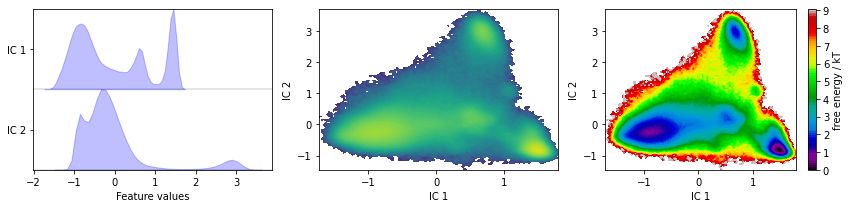

In [48]:
_,_, tica = plot_tica(baseline_model, chignolin_dataset, lag=10)

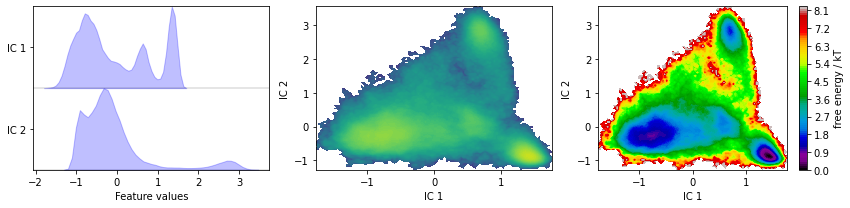

In [50]:
_,_,_ = plot_tica(baseline_model, traj, tica=tica)